[69.83240223463687, 71.50837988826815, 73.18435754189944, 72.62569832402235, 73.18435754189944, 74.30167597765363, 75.41899441340782, 76.53631284916202, 77.6536312849162, 77.09497206703911, 78.2122905027933, 79.32960893854748, 79.88826815642459, 79.88826815642459, 81.00558659217877, 81.56424581005587, 81.56424581005587, 82.68156424581005, 82.12290502793296, 82.12290502793296, 83.24022346368714, 83.24022346368714]


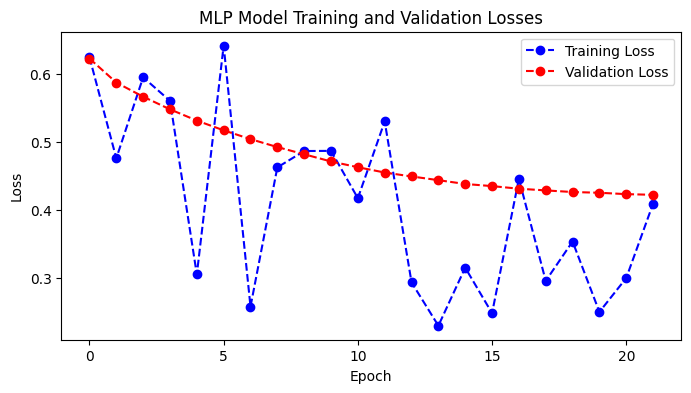

tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

In [83]:
# 325 Homework 3
# Task 1 & 2
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# set the seeds
torch.manual_seed(45)
np.random.seed(45)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class TitanicDataset(Dataset):
    def __init__(self, X, y, transformer):
        self.y = torch.tensor(y.to_numpy(), dtype=torch.long)

        X_t = transformer.transform(X)

        self.X = torch.tensor(X_t, dtype=torch.float32)
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MLP_Network(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP_Network, self).__init__()

        self.input_size = input_size

        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # go up to but not at the end
        # N-Model implementation
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_sizes[-1], num_classes))

        self.model = nn.Sequential(*layers) # unpack

    def forward(self, x):
        return self.model(x)

def weights_init_xavier(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# Adapted from Dr. Santos' Colab

def eval_model(model, test_loader, criterion):
  # Set the model to evaluation mode
  model.eval()

  # Tracking variables
  correct = 0
  total = 0
  loss = 0
  iters = 0

  # Disable gradient calculation
  with torch.no_grad():
    for X, y in test_loader:
        # Move tensors to the configured device
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        outputs = model(X)

        #Loss
        loss += criterion(outputs, y).item()
        iters += 1

        # Final prediction
        _, predicted = torch.max(outputs.data, 1)

        # Add processed samples count to total tally
        total += y.size(0)

        # Compute number of correct samples
        correct += (predicted == y).sum().item()

  # Return accuracy
  return 100 * correct/total, loss/iters      #Note this is the average batch loss, for a quick approx.

# Adapted from Dr. Santos' Colab
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, display=False):
    # Initialize output arrays
    train_losses = []
    val_losses = []
    val_accs = []

    # Initialize model weights
    model.apply(weights_init_xavier)

    # 3. Implement the training loop
    for epoch in range(num_epochs):

        # Iterate through the training set batches
        for i, (X, y) in enumerate(train_loader):

            # zero gradients
            optimizer.zero_grad()

            # Enable learning
            model.train()

            # Move tensors to the configured device
            X = X.to(device)
            y = y.to(device)
            model.to(device)

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y)

            # Backward and optimize
            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        val_acc, val_loss = eval_model(model, test_loader, criterion)

        # Append losses and validation accuracy after each epoch
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    return model, train_losses, val_losses, val_accs
    

df = pd.read_csv("/kaggle/input/titanic/train.csv")
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

y = df['Survived']
X = df.drop(columns=['Survived'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# set up the imputers
imputer_age = SimpleImputer(strategy='median')
imputer_fare = SimpleImputer(strategy='mean')
imputer_people = SimpleImputer(strategy='median')

people_cols = ['SibSp', 'Parch', 'FamilySize']

# learning note: fit_transform expects a 2D structure, so double brackets
# converts the series df['Age'] into a DataFrame

# impute first to remove NaNs before feature engineering
X_train['Age'] = imputer_age.fit_transform(X_train[['Age']]).ravel()
X_train['Fare'] = imputer_fare.fit_transform(X_train[['Fare']]).ravel()
X_val['Age'] = imputer_age.transform(X_val[['Age']]).ravel()
X_val['Fare'] = imputer_fare.transform(X_val[['Fare']]).ravel()

for se in [X_train, X_val]:
    se['FamilySize'] = se['SibSp'] + se['Parch'] + 1 # add new column for family size
    se['isAlone'] = (se['FamilySize'] == 1).astype(int)
    se['isChild'] = (se['Age'] < 18).astype(int)
    se['Age_Pclass'] = (se['Pclass'] * se['Age'])
    se['Fare_Pclass'] = (se['Pclass'] * se['Fare'])

# impute the rest
X_train[people_cols] = imputer_people.fit_transform(X_train[people_cols])
X_val[people_cols] = imputer_people.transform(X_val[people_cols])

numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'isChild', 'isAlone',
                    'Age_Pclass', 'Fare_Pclass']
categorical_features = ['Pclass', 'Sex', 'Embarked']

transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

transformer.fit(X_train)

train_set = TitanicDataset(X_train, y_train, transformer)
val_set = TitanicDataset(X_val, y_val, transformer)

train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=16, shuffle=False)

input_size = transformer.transform(X_train).shape[1]

num_classes = 2
hidden_sizes = [36, 18]
num_epochs = 22

mlp_model = MLP_Network(input_size, hidden_sizes, num_classes).to(device)
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

mlp_model, train_losses, val_losses, val_accs = train_model(mlp_model, train_dataloader,
                                                            val_dataloader, criterion,
                                                            optimizer, num_epochs,
                                                            display=False)
# Adapted from Dr. Santos' Colab
print(val_accs)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(num_epochs), train_losses, 'o--b', label='Training Loss',)
plt.plot(np.arange(num_epochs), val_losses, 'o--r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('MLP Model Training and Validation Losses')
plt.show()

# submission
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
passenger_ids = test_df['PassengerId']
X_test = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

X_test['Age'] = imputer_age.transform(X_test[['Age']]).ravel()
X_test['Fare'] = imputer_fare.transform(X_test[['Fare']]).ravel()

X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1 # add new column for family size
X_test['isAlone'] = (X_test['FamilySize'] == 1).astype(int)
X_test['isChild'] = (X_test['Age'] < 18).astype(int)
X_test['Age_Pclass'] = (X_test['Pclass'] * X_test['Age'])
X_test['Fare_Pclass'] = (X_test['Pclass'] * X_test['Fare'])

X_test[people_cols] = imputer_people.transform(X_test[people_cols])

X_test_t = transformer.transform(X_test) # transformed
X_test_t = torch.tensor(X_test_t, dtype=torch.float32) # tensor version
X_test_t = X_test_t.to(device) # move to device

mlp_model.eval()

with torch.no_grad():
    outputs = mlp_model(X_test_t)
    values, predictions = torch.max(outputs, 1)
    
    # probabilities = torch.sigmoid(outputs)
    # predictions = []
    
    # for probability in probabilities:
        # if probability > 0.5:
            # predictions.append(1)
        # else:
            # predictions.append(0)

predictions.cpu().numpy()

print(predictions)
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': predictions
})
filename = 'Titanic-Submission.csv'
submission.to_csv(filename, index=False)

#36 options
depths = [2, 3]
hidden_starts = [input_size*2, input_size*3]
lrs = [0.01, 0.001, 0.0001]
l2_reg_weights = [0.05, 0.005, 0.0005]
num_epochs = 40

results = []
for depth in depths:
    for hidden_start in hidden_starts:

        hidden_sizes = []

        # ensuring that depth and # of hidden sizes match
        cur_size = hidden_start
        for i in range(depth):
            hidden_sizes.append(cur_size)
            cur_size = cur_size // 2
        
        for lr in lrs:
            for weight in l2_reg_weights:

                

                mlp_model = MLP_Network(input_size, hidden_sizes, num_classes).to(device)
                
                optimizer = optim.SGD(mlp_model.parameters(), lr=lr, weight_decay=weight)
                criterion = nn.CrossEntropyLoss()
                
                mlp_model, train_losses, val_losses, val_accs = train_model(mlp_model, train_dataloader,
                                                            val_dataloader, criterion,
                                                            optimizer, num_epochs,
                                                            display=False)
                results.append({
                    "depth": depth,
                    "hidden_sizes": hidden_sizes,
                    "lr": lr,
                    "weight_decay": weight,
                    "best_val_acc": max(val_accs),
                    "best_val_loss": min(val_losses)
                })
                
res_df = pd.DataFrame(results)
print(res_df)

Original feature dimension: 18
PCA feature dimension: 7


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


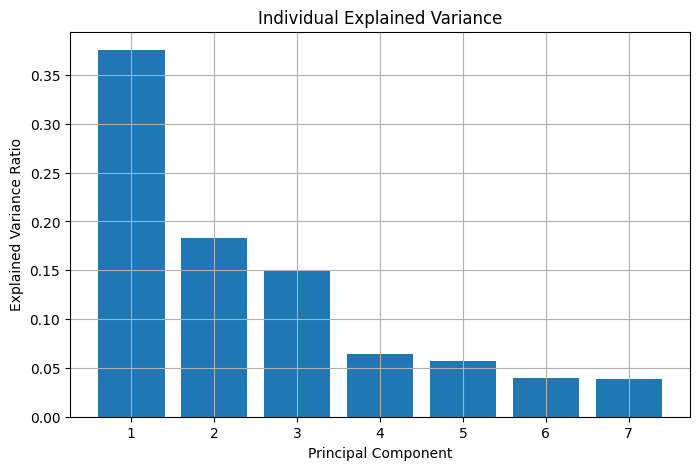

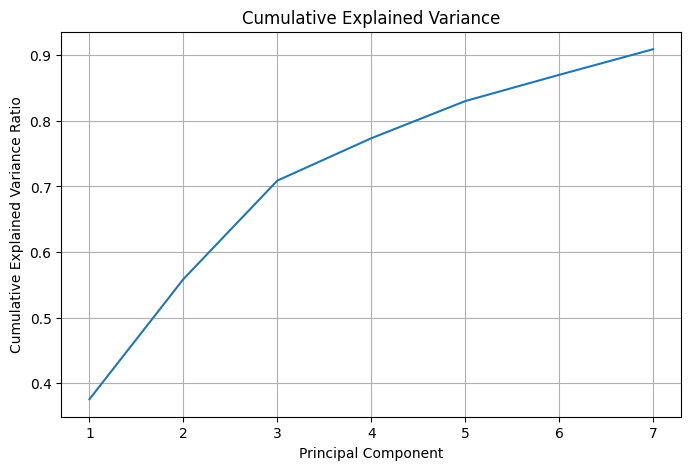

[63.687150837988824, 65.92178770949721, 69.27374301675978, 71.50837988826815, 72.06703910614524, 73.74301675977654, 74.30167597765363, 74.86033519553072, 73.74301675977654, 74.86033519553072, 73.74301675977654, 73.18435754189944, 74.86033519553072, 74.86033519553072, 75.97765363128492, 75.97765363128492, 77.09497206703911, 78.2122905027933, 77.6536312849162, 78.2122905027933, 78.77094972067039, 79.88826815642459]


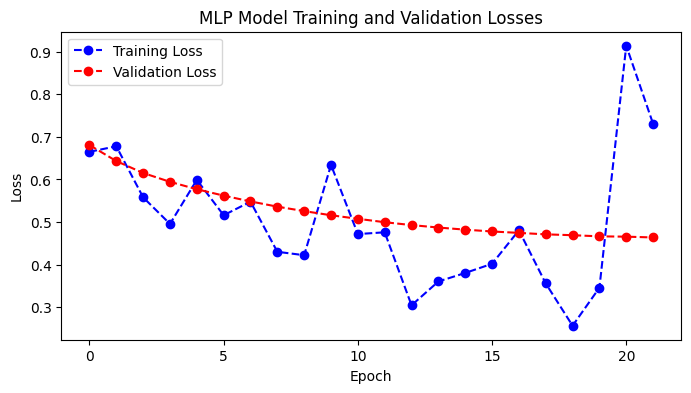

tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

In [80]:
# COSC 325 Homework 3
# Task 3, PCA for MLP

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# set the seeds
torch.manual_seed(45)
np.random.seed(45)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class TitanicPCADataset(Dataset):
    def __init__(self, X, y):
        self.y = torch.tensor(y.to_numpy(), dtype=torch.long)
        self.X = torch.tensor(X, dtype=torch.float32)
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
class MLP_Network(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP_Network, self).__init__()

        self.input_size = input_size

        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # go up to but not at the end
        # N-Model implementation
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_sizes[-1], num_classes))

        self.model = nn.Sequential(*layers) # unpack

    def forward(self, x):
        return self.model(x)

def weights_init_xavier(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# Adapted from Dr. Santos' Colab

def eval_model(model, test_loader, criterion):
  # Set the model to evaluation mode
  model.eval()

  # Tracking variables
  correct = 0
  total = 0
  loss = 0
  iters = 0

  # Disable gradient calculation
  with torch.no_grad():
    for X, y in test_loader:
        # Move tensors to the configured device
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        outputs = model(X)

        #Loss
        loss += criterion(outputs, y).item()
        iters += 1

        # Final prediction
        _, predicted = torch.max(outputs.data, 1)

        # Add processed samples count to total tally
        total += y.size(0)

        # Compute number of correct samples
        correct += (predicted == y).sum().item()

  # Return accuracy
  return 100 * correct/total, loss/iters      #Note this is the average batch loss, for a quick approx.

# Adapted from Dr. Santos' Colab
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, display=False):
    # Initialize output arrays
    train_losses = []
    val_losses = []
    val_accs = []

    # Initialize model weights
    model.apply(weights_init_xavier)

    # 3. Implement the training loop
    for epoch in range(num_epochs):

        # Iterate through the training set batches
        for i, (X, y) in enumerate(train_loader):

            # zero gradients
            optimizer.zero_grad()

            # Enable learning
            model.train()

            # Move tensors to the configured device
            X = X.to(device)
            y = y.to(device)
            model.to(device)

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y)

            # Backward and optimize
            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        val_acc, val_loss = eval_model(model, test_loader, criterion)

        # Append losses and validation accuracy after each epoch
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    return model, train_losses, val_losses, val_accs
    

df = pd.read_csv("/kaggle/input/titanic/train.csv")
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

y = df['Survived']
X = df.drop(columns=['Survived'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# set up the imputers
imputer_age = SimpleImputer(strategy='median')
imputer_fare = SimpleImputer(strategy='mean')
imputer_people = SimpleImputer(strategy='median')

people_cols = ['SibSp', 'Parch', 'FamilySize']

# learning note: fit_transform expects a 2D structure, so double brackets
# converts the series df['Age'] into a DataFrame

# impute first to remove NaNs before feature engineering
X_train['Age'] = imputer_age.fit_transform(X_train[['Age']]).ravel()
X_train['Fare'] = imputer_fare.fit_transform(X_train[['Fare']]).ravel()

X_val['Age'] = imputer_age.transform(X_val[['Age']]).ravel()
X_val['Fare'] = imputer_fare.transform(X_val[['Fare']]).ravel()

for se in [X_train, X_val]:
    se['FamilySize'] = se['SibSp'] + se['Parch'] + 1 # add new column for family size
    se['isAlone'] = (se['FamilySize'] == 1).astype(int)
    se['isChild'] = (se['Age'] < 18).astype(int)
    se['Age_Pclass'] = (se['Pclass'] * se['Age'])
    se['Fare_Pclass'] = (se['Pclass'] * se['Fare'])

# impute the rest
X_train[people_cols] = imputer_people.fit_transform(X_train[people_cols])
X_val[people_cols] = imputer_people.transform(X_val[people_cols])

numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'isChild', 'isAlone',
                    'Age_Pclass', 'Fare_Pclass']
categorical_features = ['Pclass', 'Sex', 'Embarked']

transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

transformer.fit(X_train)

X_train_t = transformer.transform(X_train)
X_val_t = transformer.transform(X_val)

pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_t)
X_val_pca = pca.transform(X_val_t)

print(f'Original feature dimension: {X_train_t.shape[1]}')
print(f'PCA feature dimension: {X_train_pca.shape[1]}')

evr = pca.explained_variance_ratio_
plt.figure(figsize=(8,5))
plt.bar(range(1, len(evr)+1), evr)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Explained Variance')
plt.grid(True)
plt.show()

cumulative_evr = np.cumsum(evr)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_evr)+1), cumulative_evr)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.show()

train_pca_set = TitanicPCADataset(X_train_pca, y_train)
val_pca_set = TitanicPCADataset(X_val_pca, y_val)

train_dataloader = DataLoader(train_pca_set, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_pca_set, batch_size=16, shuffle=False)

input_size = X_train_pca.shape[1]

num_classes = 2
hidden_sizes = [36, 18]
num_epochs = 22

mlp_model = MLP_Network(input_size, hidden_sizes, num_classes).to(device)
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

mlp_model, train_losses, val_losses, val_accs = train_model(mlp_model, train_dataloader,
                                                            val_dataloader, criterion,
                                                            optimizer, num_epochs,
                                                            display=False)
# Adapted from Dr. Santos' Colab
print(val_accs)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(num_epochs), train_losses, 'o--b', label='Training Loss',)
plt.plot(np.arange(num_epochs), val_losses, 'o--r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('MLP Model Training and Validation Losses')
plt.show()

# submission
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
passenger_ids = test_df['PassengerId']
X_test = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

X_test['Age'] = imputer_age.transform(X_test[['Age']]).ravel()
X_test['Fare'] = imputer_fare.transform(X_test[['Fare']]).ravel()

X_test[['Age', 'Fare']] = X_test[['Age', 'Fare']].fillna(0)
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1 # add new column for family size
X_test['isAlone'] = (X_test['FamilySize'] == 1).astype(int)
X_test['isChild'] = (X_test['Age'] < 18).astype(int)
X_test['Age_Pclass'] = (X_test['Pclass'] * X_test['Age'])
X_test['Fare_Pclass'] = (X_test['Pclass'] * X_test['Fare'])

X_test[people_cols] = imputer_people.transform(X_test[people_cols])

X_test_t = transformer.transform(X_test) # transformed
X_test_pca = pca.transform(X_test_t)
X_test_pca = torch.tensor(X_test_pca, dtype=torch.float32) # tensor version
X_test_pca = X_test_pca.to(device) # move to device

mlp_model.eval()

with torch.no_grad():
    outputs = mlp_model(X_test_pca)
    values, predictions = torch.max(outputs, 1)
    
    # probabilities = torch.sigmoid(outputs)
    # predictions = []
    
    # for probability in probabilities:
        # if probability > 0.5:
            # predictions.append(1)
        # else:
            # predictions.append(0)

predictions.cpu().numpy()

print(predictions)
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': predictions
})
filename = 'Titanic-Submission.csv'
submission.to_csv(filename, index=False)

Original feature dimension: 18
PCA feature dimension: 7


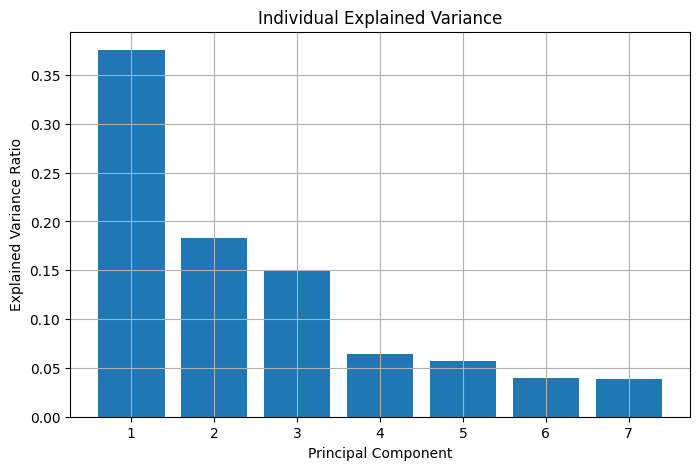

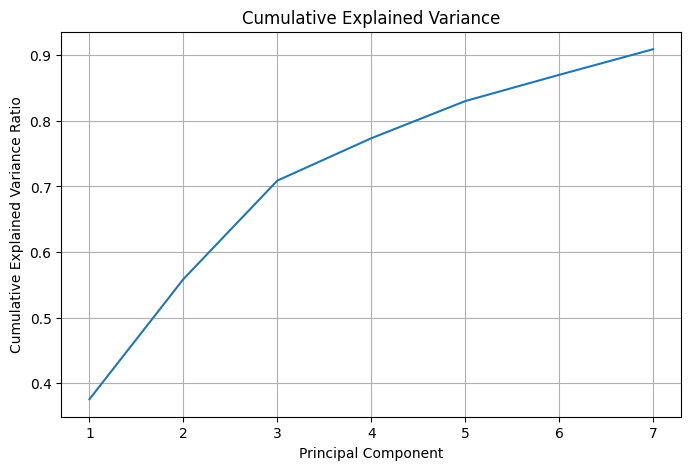

In [81]:
# COSC 325 Homework 3
# Task 3, PCA for Logistic Regression

from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt


df = pd.read_csv("/kaggle/input/titanic/train.csv")
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# data preparation
y = df['Survived']
X = df.drop(columns=['Survived'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# set up the imputers
imputer_age = SimpleImputer(strategy='median')
imputer_fare = SimpleImputer(strategy='mean')
imputer_people = SimpleImputer(strategy='median')

people_cols = ['SibSp', 'Parch', 'FamilySize']

# learning note: fit_transform expects a 2D structure, so double brackets
# converts the series df['Age'] into a DataFrame

# impute first to remove NaNs before feature engineering
X_train['Age'] = imputer_age.fit_transform(X_train[['Age']]).ravel()
X_train['Fare'] = imputer_fare.fit_transform(X_train[['Fare']]).ravel()

X_val['Age'] = imputer_age.transform(X_val[['Age']]).ravel()
X_val['Fare'] = imputer_fare.transform(X_val[['Fare']]).ravel()

for se in [X_train, X_val]:
    se['FamilySize'] = se['SibSp'] + se['Parch'] + 1 # add new column for family size
    se['isAlone'] = (se['FamilySize'] == 1).astype(int)
    se['isChild'] = (se['Age'] < 18).astype(int)
    se['Age_Pclass'] = (se['Pclass'] * se['Age'])
    se['Fare_Pclass'] = (se['Pclass'] * se['Fare'])

# impute the rest
X_train[people_cols] = imputer_people.fit_transform(X_train[people_cols])
X_val[people_cols] = imputer_people.transform(X_val[people_cols])

numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'isChild', 'isAlone',
                    'Age_Pclass', 'Fare_Pclass']
categorical_features = ['Pclass', 'Sex', 'Embarked']

transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

transformer.fit(X_train)

X_train_t = transformer.transform(X_train)
X_val_t = transformer.transform(X_val)

pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_t)
X_val_pca = pca.transform(X_val_t)

print(f'Original feature dimension: {X_train_t.shape[1]}')
print(f'PCA feature dimension: {X_train_pca.shape[1]}')

evr = pca.explained_variance_ratio_
plt.figure(figsize=(8,5))
plt.bar(range(1, len(evr)+1), evr)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Explained Variance')
plt.grid(True)
plt.show()

cumulative_evr = np.cumsum(evr)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_evr)+1), cumulative_evr)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# submission
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
passenger_ids = test_df['PassengerId']
X_test = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

X_test['Age'] = imputer_age.transform(X_test[['Age']]).ravel()
X_test['Fare'] = imputer_fare.transform(X_test[['Fare']]).ravel()

X_test[['Age', 'Fare']] = X_test[['Age', 'Fare']].fillna(0)
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1 # add new column for family size
X_test['isAlone'] = (X_test['FamilySize'] == 1).astype(int)
X_test['isChild'] = (X_test['Age'] < 18).astype(int)
X_test['Age_Pclass'] = (X_test['Pclass'] * X_test['Age'])
X_test['Fare_Pclass'] = (X_test['Pclass'] * X_test['Fare'])

X_test[people_cols] = imputer_people.transform(X_test[people_cols])

X_test_t = transformer.transform(X_test) # transformed
X_test_pca = pca.transform(X_test_t)

models = []
train_cost = []
val_cost = []

# no regularization
model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
model.fit(X_train_pca, y_train)
models.append('No Reg')
train_cost.append(log_loss(y_train, model.predict_proba(X_train_pca)[:, 1]))
val_cost.append(log_loss(y_val, model.predict_proba(X_val_pca)[:, 1]))

predictions = model.predict(X_test_pca)
submission = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})
filename = 'Titanic-Submission-LogRegPCA.csv'
submission.to_csv(filename, index=False)

In [82]:
# COSC 325 Homework 3
# PCA for RF

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv("/kaggle/input/titanic/train.csv")
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# data preparation
y = df['Survived']
X = df.drop(columns=['Survived'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# set up the imputers
imputer_age = SimpleImputer(strategy='median')
imputer_fare = SimpleImputer(strategy='mean')
imputer_people = SimpleImputer(strategy='median')

people_cols = ['SibSp', 'Parch', 'FamilySize']

# learning note: fit_transform expects a 2D structure, so double brackets
# converts the series df['Age'] into a DataFrame

# impute first to remove NaNs before feature engineering
X_train['Age'] = imputer_age.fit_transform(X_train[['Age']]).ravel()
X_train['Fare'] = imputer_fare.fit_transform(X_train[['Fare']]).ravel()

X_val['Age'] = imputer_age.transform(X_val[['Age']]).ravel()
X_val['Fare'] = imputer_fare.transform(X_val[['Fare']]).ravel()

for se in [X_train, X_val]:
    se['FamilySize'] = se['SibSp'] + se['Parch'] + 1 # add new column for family size
    se['isAlone'] = (se['FamilySize'] == 1).astype(int)
    se['isChild'] = (se['Age'] < 18).astype(int)
    se['Age_Pclass'] = (se['Pclass'] * se['Age'])
    se['Fare_Pclass'] = (se['Pclass'] * se['Fare'])

# impute the rest
X_train[people_cols] = imputer_people.fit_transform(X_train[people_cols])
X_val[people_cols] = imputer_people.transform(X_val[people_cols])

numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'isChild', 'isAlone',
                    'Age_Pclass', 'Fare_Pclass']
categorical_features = ['Pclass', 'Sex', 'Embarked']

transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

transformer.fit(X_train)

X_train_t = transformer.transform(X_train)
X_val_t = transformer.transform(X_val)

pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_t)
X_val_pca = pca.transform(X_val_t)

# submission
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
passenger_ids = test_df['PassengerId']
X_test = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

X_test['Age'] = imputer_age.transform(X_test[['Age']]).ravel()
X_test['Fare'] = imputer_fare.transform(X_test[['Fare']]).ravel()

X_test[['Age', 'Fare']] = X_test[['Age', 'Fare']].fillna(0)
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1 # add new column for family size
X_test['isAlone'] = (X_test['FamilySize'] == 1).astype(int)
X_test['isChild'] = (X_test['Age'] < 18).astype(int)
X_test['Age_Pclass'] = (X_test['Pclass'] * X_test['Age'])
X_test['Fare_Pclass'] = (X_test['Pclass'] * X_test['Fare'])

X_test[people_cols] = imputer_people.transform(X_test[people_cols])

X_test_t = transformer.transform(X_test) # transformed
X_test_pca = pca.transform(X_test_t)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=32,
    min_samples_split=4,
    min_samples_leaf=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_pca, y_train)
tacc = rf_model.score(X_train_pca, y_train)
vacc = rf_model.score(X_val_pca, y_val)

print(tacc)
print(vacc)
predictions = rf_model.predict(X_test_pca)
submission = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})
filename = 'Titanic-Submission-RFPCA.csv'
submission.to_csv(filename, index=False)

0.9480337078651685
0.7932960893854749
